### Imports and Mounting Drive

In [1]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

Mounted at /gdrive


In [2]:
%load_ext autoreload
%autoreload 2
from functions import *

np.random.seed(17)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the Data

In [3]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
276558,The Phenomenology Of Spirit,Hegel,german_idealism,One difficulty which should be avoided comes f...,One difficulty which should be avoided comes f...,238,one difficulty which should be avoided comes f...,"['one', 'difficulty', 'which', 'should', 'be',...",one difficulty which should be avoid come fro...
172417,Naming And Necessity,Kripke,analytic,He may not think that this picks out anyone un...,He may not think that this picks out anyone un...,53,he may not think that this picks out anyone un...,"['he', 'may', 'not', 'think', 'that', 'this', ...",-PRON- may not think that this pick out anyon...
45021,Aristotle - Complete Works,Aristotle,aristotle,Now if someone were to ask 'Is a thing that wh...,Now if someone were to ask 'Is a thing that wh...,62,now if someone were to ask 'is a thing that wh...,"['now', 'if', 'someone', 'were', 'to', 'ask', ...",now if someone be to ask ' be a thing that wh...
183256,Philosophical Troubles,Kripke,analytic,According to the Karttunen and Peters filterin...,According to the Karttunen and Peters filterin...,102,according to the karttunen and peters filterin...,"['according', 'to', 'the', 'karttunen', 'and',...",accord to the Karttunen and Peters filtering ...
240186,Off The Beaten Track,Heidegger,phenomenology,"As knowing, preservation of the work is the so...","As knowing, preservation of the work is the so...",120,"as knowing, preservation of the work is the so...","['as', 'knowing', 'preservation', 'of', 'the',...","as know , preservation of the work be the sob..."


### Build a Baseline LSTM Model

In [4]:
# make the labels numerical
school_label_dict = {'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}
flipped_dict = {value:key for key, value in school_label_dict.items()}

x = df['sentence_str']
y = df['school'].apply(lambda x: school_label_dict[x])

x_train, x_test, y_train, y_test = train_test_split(x,y)

In [5]:
# get class weights
weights= compute_class_weight(
           'balanced',
            np.unique(y_train), 
            y_train)

weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

{0: 0.6071856736100705,
 1: 0.6638041667804385,
 2: 1.7856985456148082,
 3: 1.8093554629353974,
 4: 0.9626014650564245,
 5: 1.6317962142569473,
 6: 0.7686871561373554,
 7: 1.1345202538734367,
 8: 0.8425056316063074,
 9: 1.4026367412877914}

In [6]:
y_train_seq = to_categorical(y_train)
y_test_seq = to_categorical(y_test)

In [7]:
tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# check what to our max sequence length should be 
max(list(map(lambda x: len(x),[*train_sequences,*test_sequences])))

415

In [8]:
from google.colab import files

# save the tokenizer so we can use the model on new texts
tokenizer_pkl = open('baseline_tokenizer.pkl', 'wb')
pickle.dump(tokenizer, tokenizer_pkl)
files.download('baseline_tokenizer.pkl')
tokenizer_pkl.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# do the relevant padding
max_length = 450

x_train_seq = sequence.pad_sequences(train_sequences, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=max_length)

In [10]:
# check how many distinct words are in the corpus
len(tokenizer.index_word)

84798

In [11]:
# set up callbacks
model_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP/checkpoints'

def set_early_stop(monitor='val_accuracy',patience=3, restore_best_weights=True,
                   min_delta=0.01, verbose=1):
  args = locals()
  return EarlyStopping(**args)

def set_checkpoint(monitor='val_accuracy',model_subfolder=model_path, verbose=0):
  filepath = model_subfolder+ "/NN_weights_epoch:{epoch:02d}_{"+monitor+":.4f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=verbose,
                                 save_best_only=True, mode='auto')
  return checkpoint

def list_callbacks(checkpoints=True, early_stopping=True, modeling_folder=model_path,
                   monitor_checkpoint='val_accuracy',monitor_stopping='val_accuracy',
                   min_delta=0.001, patience=3, ck_verbose=0, es_verbose=1, 
                   restore_best_weights=True):
  callbacks = []
  if checkpoints:
      callbacks.append(set_checkpoint(monitor=monitor_checkpoint,
                                      model_subfolder=modeling_folder,
                                      verbose=ck_verbose))

  if early_stopping:
      callbacks.append(set_early_stop(monitor=monitor_stopping, min_delta=min_delta,
                                      patience=patience,verbose=es_verbose,
                                      restore_best_weights=restore_best_weights))
  return callbacks

list_callbacks()

In [12]:
def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         21708544  
_________________________________________________________________
lstm (LSTM)                  (None, 50)                61400     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 21,770,454
Trainable params: 21,770,454
Non-trainable params: 0
_________________________________________________________________


None

In [13]:
history = model.fit(x_train_seq, y_train_seq, epochs=10,
                    batch_size=256, validation_split=0.2,
                    callbacks=list_callbacks(),
                    class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 136s 175ms/step - loss: 1.4893 - accuracy: 0.4839 - val_loss: 0.7496 - val_accuracy: 0.7571
Epoch 2/10
760/760 [==============================] - 132s 173ms/step - loss: 0.5456 - accuracy: 0.8215 - val_loss: 0.7031 - val_accuracy: 0.7743
Epoch 3/10
760/760 [==============================] - 132s 173ms/step - loss: 0.3855 - accuracy: 0.8728 - val_loss: 0.7076 - val_accuracy: 0.7798
Epoch 4/10
760/760 [==============================] - 130s 170ms/step - loss: 0.3072 - accuracy: 0.8962 - val_loss: 0.7501 - val_accuracy: 0.7744
Epoch 5/10
760/760 [==============================] - 130s 170ms/step - loss: 0.2561 - accuracy: 0.9121 - val_loss: 0.7909 - val_accuracy: 0.7755
Epoch 6/10
760/760 [==============================] - 129s 170ms/step - loss: 0.2234 - accuracy: 0.9225 - val_loss: 0.8269 - val_accuracy: 0.7737
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


Not bad! We got a stronger model than the Bayesian models on our first try. Hopefully this can be improved with some more tweaking. First though, let's take a look at charts regarding our final result.

In [14]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

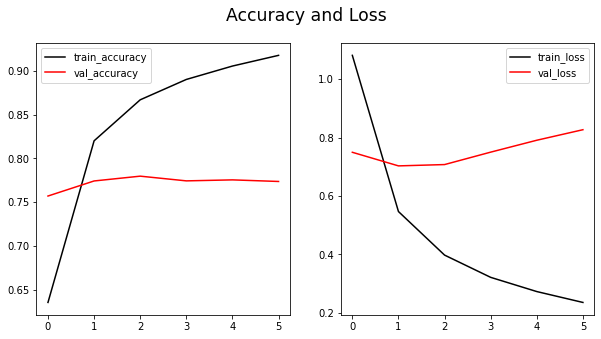

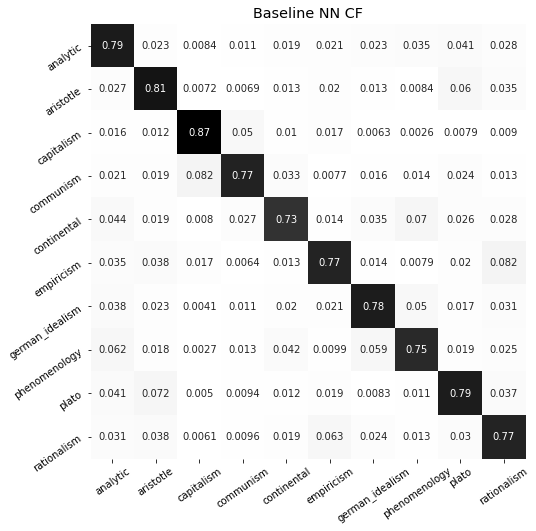




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     13407
           1       0.83      0.81      0.82     12156
           2       0.82      0.87      0.84      4580
           3       0.76      0.77      0.77      4523
           4       0.82      0.73      0.77      8526
           5       0.71      0.77      0.74      5033
           6       0.84      0.78      0.81     10511
           7       0.73      0.75      0.74      7145
           8       0.77      0.79      0.78      9536
           9       0.64      0.77      0.70      5618

    accuracy                           0.78     81035
   macro avg       0.77      0.78      0.78     81035
weighted avg       0.79      0.78      0.78     81035



In [15]:
summarize_model(history, test, preds, labels=flipped_dict, title='Baseline NN CF')

Seems good, though it did overfit towards the end. The flat accuracy curve seems to indicate that training did not actually help the model much at all, actually. 

Still, neural nets seem like they might be the way to go - let's try some options out!



### Hyperparameter Tuning

#### Try Using RMSprop instead of Adam

A different optimizer might help fix the lack of actual training improvement we saw in the last network. Here we try RMSprop.

In [16]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, 
                                                                                     tokenizer_name='rmsprop_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         21738496  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                61400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 21,800,406
Trainable params: 21,800,406
Non-trainable params: 0
_________________________________________________________________


None

In [17]:
RMSprop_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 92s 120ms/step - loss: 1.5490 - accuracy: 0.4703 - val_loss: 0.8185 - val_accuracy: 0.7367
Epoch 2/10
760/760 [==============================] - 91s 119ms/step - loss: 0.6752 - accuracy: 0.7805 - val_loss: 0.7098 - val_accuracy: 0.7691
Epoch 3/10
760/760 [==============================] - 91s 119ms/step - loss: 0.5476 - accuracy: 0.8192 - val_loss: 0.6650 - val_accuracy: 0.7855
Epoch 4/10
760/760 [==============================] - 91s 120ms/step - loss: 0.4915 - accuracy: 0.8367 - val_loss: 0.6666 - val_accuracy: 0.7830
Epoch 5/10
760/760 [==============================] - 91s 119ms/step - loss: 0.4507 - accuracy: 0.8492 - val_loss: 0.6591 - val_accuracy: 0.7864
Epoch 6/10
760/760 [==============================] - 91s 120ms/step - loss: 0.4208 - accuracy: 0.8603 - val_loss: 0.6575 - val_accuracy: 0.7884
Epoch 7/10
760/760 [==============================] - 91s 120ms/step - loss: 0.3852 - accuracy: 0.8706 - val_loss: 0.6638 - val_ac

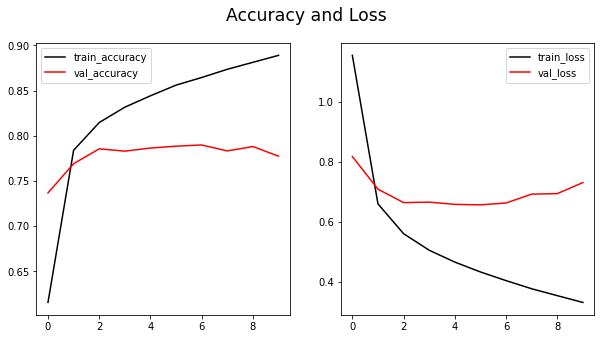

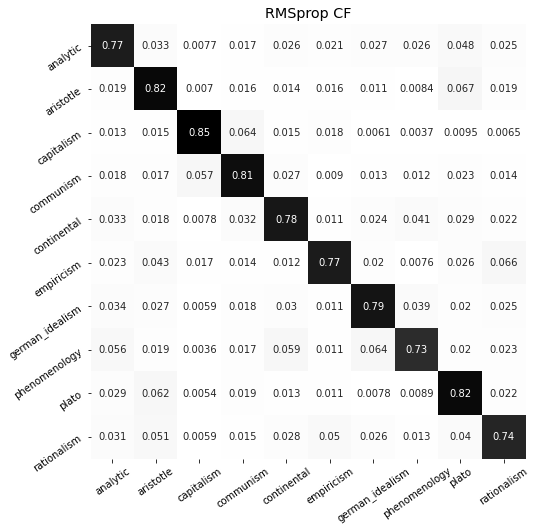




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.77      0.80     13197
           1       0.82      0.82      0.82     12252
           2       0.84      0.85      0.84      4613
           3       0.69      0.81      0.75      4562
           4       0.79      0.78      0.78      8423
           5       0.75      0.77      0.76      4969
           6       0.84      0.79      0.82     10371
           7       0.78      0.73      0.75      7203
           8       0.76      0.82      0.79      9674
           9       0.70      0.74      0.72      5771

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [18]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(RMSprop_history, test, preds, labels=flipped_dict, title='RMSprop CF')

This looks pretty good, in fact it's the best one yet at 79.3% accuracy over 10 classes. We have some of the same issues with not learning as much, but it did seem to do a bit better than Adam. 

Let's try GRU instead of LSTM next. 

#### Try Using GRU instead of LSTM

In [19]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, 
                                                                                     tokenizer_name='gru_tokenizer.pkl')

# Trying out GRU
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(GRU(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         10852736  
_________________________________________________________________
gru (GRU)                    (None, 50)                27000     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 10,880,246
Trainable params: 10,880,246
Non-trainable params: 0
_________________________________________________________________


None

In [20]:
GRU_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 67s 86ms/step - loss: 1.7384 - accuracy: 0.3704 - val_loss: 1.0354 - val_accuracy: 0.6571
Epoch 2/10
760/760 [==============================] - 63s 83ms/step - loss: 0.8552 - accuracy: 0.7173 - val_loss: 0.7773 - val_accuracy: 0.7476
Epoch 3/10
760/760 [==============================] - 65s 85ms/step - loss: 0.6420 - accuracy: 0.7892 - val_loss: 0.7328 - val_accuracy: 0.7605
Epoch 4/10
760/760 [==============================] - 65s 85ms/step - loss: 0.5477 - accuracy: 0.8197 - val_loss: 0.7046 - val_accuracy: 0.7732
Epoch 5/10
760/760 [==============================] - 65s 85ms/step - loss: 0.4862 - accuracy: 0.8401 - val_loss: 0.6845 - val_accuracy: 0.7812
Epoch 6/10
760/760 [==============================] - 65s 85ms/step - loss: 0.4464 - accuracy: 0.8520 - val_loss: 0.6518 - val_accuracy: 0.7901
Epoch 7/10
760/760 [==============================] - 65s 85ms/step - loss: 0.4224 - accuracy: 0.8585 - val_loss: 0.6626 - val_accuracy:

GRU seems to be not appreciably different than LSTM on this task.



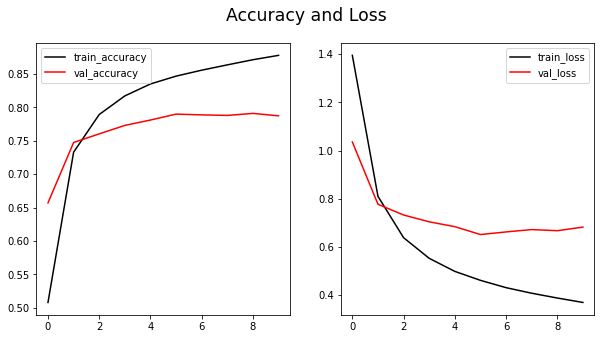

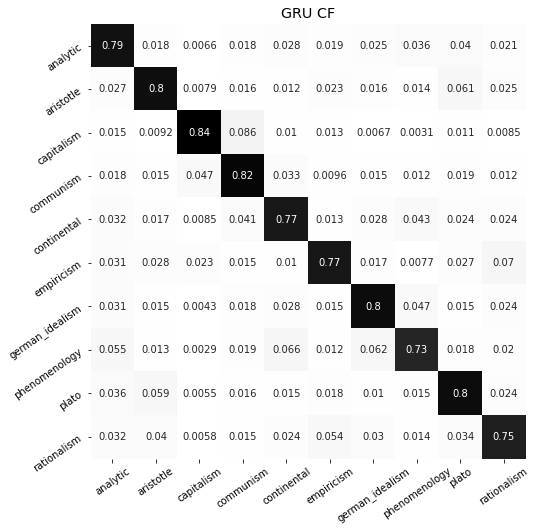




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     13576
           1       0.85      0.80      0.82     12145
           2       0.84      0.84      0.84      4466
           3       0.67      0.82      0.74      4486
           4       0.78      0.77      0.78      8507
           5       0.73      0.77      0.75      5068
           6       0.83      0.80      0.82     10372
           7       0.74      0.73      0.74      7129
           8       0.77      0.80      0.79      9577
           9       0.70      0.75      0.72      5709

    accuracy                           0.79     81035
   macro avg       0.77      0.79      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [21]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(GRU_history, test, preds, labels=flipped_dict, title='GRU CF')

79% accuracy, as before, and with the same tendency to stop learning quite quickly. Still, it does learn better than adam version we have run in the past. 

#### Bidirectional LSTM

In [22]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, 
                                                                                     tokenizer_name='bidirectional_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         10876288  
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               71600     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 10,948,898
Trainable params: 10,948,898
Non-trainable params: 0
_________________________________________________________________


None

In [23]:
bidirectional_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 92s 117ms/step - loss: 1.6877 - accuracy: 0.3908 - val_loss: 0.9111 - val_accuracy: 0.7048
Epoch 2/10
760/760 [==============================] - 88s 116ms/step - loss: 0.8002 - accuracy: 0.7392 - val_loss: 0.7599 - val_accuracy: 0.7519
Epoch 3/10
760/760 [==============================] - 88s 116ms/step - loss: 0.6154 - accuracy: 0.7980 - val_loss: 0.6893 - val_accuracy: 0.7774
Epoch 4/10
760/760 [==============================] - 89s 117ms/step - loss: 0.5368 - accuracy: 0.8230 - val_loss: 0.6731 - val_accuracy: 0.7826
Epoch 5/10
760/760 [==============================] - 89s 117ms/step - loss: 0.4897 - accuracy: 0.8366 - val_loss: 0.6763 - val_accuracy: 0.7813
Epoch 6/10
760/760 [==============================] - 89s 117ms/step - loss: 0.4581 - accuracy: 0.8462 - val_loss: 0.6919 - val_accuracy: 0.7784
Epoch 7/10
760/760 [==============================] - 88s 116ms/step - loss: 0.4348 - accuracy: 0.8549 - val_loss: 0.6970 - val_ac

Looks good, more or less on par with the baseline unidirectional LSTM. 

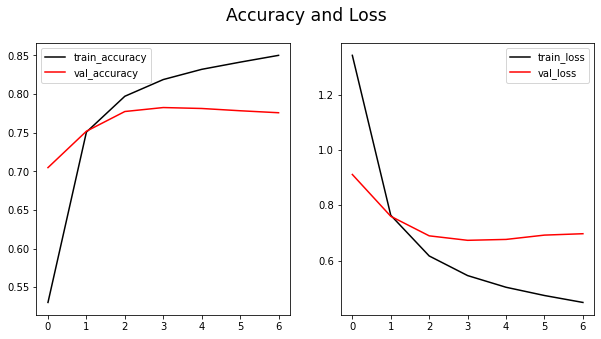

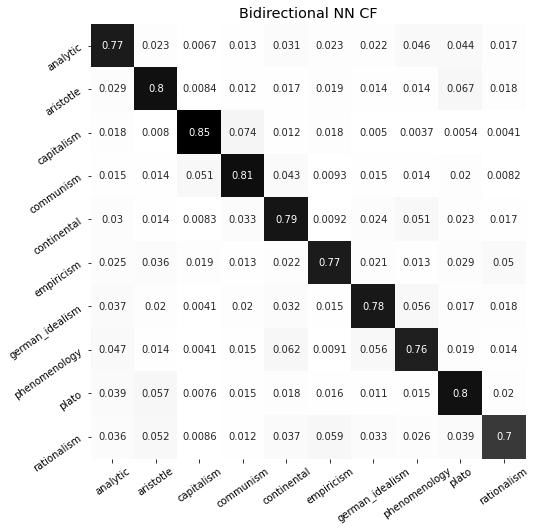




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     13549
           1       0.84      0.80      0.82     12274
           2       0.83      0.85      0.84      4608
           3       0.70      0.81      0.75      4416
           4       0.76      0.79      0.77      8438
           5       0.73      0.77      0.75      4996
           6       0.84      0.78      0.81     10368
           7       0.70      0.76      0.73      7024
           8       0.76      0.80      0.78      9579
           9       0.75      0.70      0.72      5783

    accuracy                           0.78     81035
   macro avg       0.77      0.78      0.78     81035
weighted avg       0.79      0.78      0.78     81035



In [24]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Bidirectional NN CF')

This printout could be the one we saw before. Still some overtraining - we probably don't need all 10 epochs. 

#### Multiple LSTM Layers 

Next, let's try training a model with multiple LSTM layers to see if that improves performance.

In [25]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, 
                                                                                     tokenizer_name='multi_lstm_tokenizer.pkl')

# commented out layers indicate past attempts
# none were particularly successful
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         10823936  
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 10,880,446
Trainable params: 10,880,446
Non-trainable params: 0
_________________________________________________________________


None

In [26]:
multi_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 86s 109ms/step - loss: 1.6296 - accuracy: 0.4022 - val_loss: 0.9583 - val_accuracy: 0.6814
Epoch 2/10
760/760 [==============================] - 83s 109ms/step - loss: 0.8188 - accuracy: 0.7305 - val_loss: 0.7521 - val_accuracy: 0.7547
Epoch 3/10
760/760 [==============================] - 83s 110ms/step - loss: 0.6186 - accuracy: 0.7965 - val_loss: 0.7055 - val_accuracy: 0.7709
Epoch 4/10
760/760 [==============================] - 83s 109ms/step - loss: 0.5416 - accuracy: 0.8203 - val_loss: 0.7243 - val_accuracy: 0.7636
Epoch 5/10
760/760 [==============================] - 83s 109ms/step - loss: 0.4874 - accuracy: 0.8367 - val_loss: 0.6574 - val_accuracy: 0.7880
Epoch 6/10
760/760 [==============================] - 83s 110ms/step - loss: 0.4579 - accuracy: 0.8472 - val_loss: 0.6791 - val_accuracy: 0.7817
Epoch 7/10
760/760 [==============================] - 84s 110ms/step - loss: 0.4277 - accuracy: 0.8559 - val_loss: 0.6484 - val_ac

Similar result again, though our best model so far with almost 80% accuracy. 

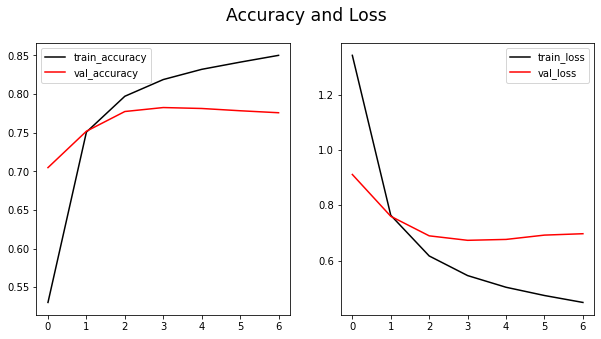

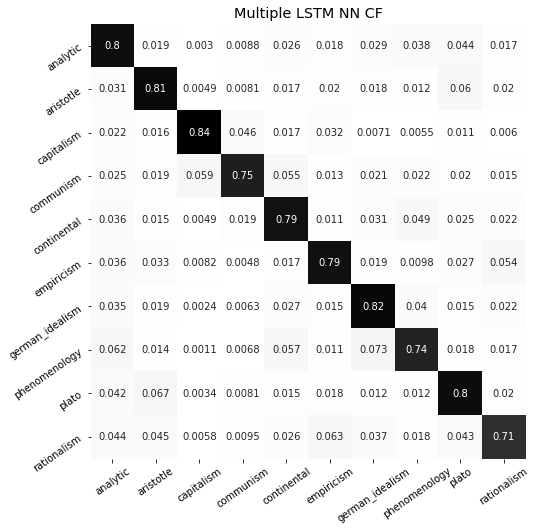




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     13480
           1       0.84      0.81      0.82     12127
           2       0.87      0.84      0.86      4537
           3       0.80      0.75      0.77      4475
           4       0.78      0.79      0.78      8501
           5       0.72      0.79      0.75      4975
           6       0.82      0.82      0.82     10609
           7       0.74      0.74      0.74      7110
           8       0.77      0.80      0.78      9539
           9       0.72      0.71      0.72      5682

    accuracy                           0.79     81035
   macro avg       0.79      0.78      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [27]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Multiple LSTM NN CF')

More or less the same as past models. More layers don't seem to hurt (except when it comes to training time), but they don't seem to help much either. 

#### More LSTM Neurons

In [28]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y,
                                                                                     tokenizer_name='extra_lstm_nn_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(100, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         10842624  
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 10,935,234
Trainable params: 10,935,234
Non-trainable params: 0
_________________________________________________________________


None

In [29]:
extra_LSTM_neurons_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=set_early_stop(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 65s 84ms/step - loss: 1.6041 - accuracy: 0.4356 - val_loss: 0.8442 - val_accuracy: 0.7261
Epoch 2/10
760/760 [==============================] - 63s 83ms/step - loss: 0.7367 - accuracy: 0.7602 - val_loss: 0.7272 - val_accuracy: 0.7660
Epoch 3/10
760/760 [==============================] - 63s 83ms/step - loss: 0.5876 - accuracy: 0.8066 - val_loss: 0.7029 - val_accuracy: 0.7753
Epoch 4/10
760/760 [==============================] - 63s 83ms/step - loss: 0.5116 - accuracy: 0.8303 - val_loss: 0.6749 - val_accuracy: 0.7825
Epoch 5/10
760/760 [==============================] - 64s 84ms/step - loss: 0.4755 - accuracy: 0.8424 - val_loss: 0.6493 - val_accuracy: 0.7916
Epoch 6/10
760/760 [==============================] - 63s 83ms/step - loss: 0.4492 - accuracy: 0.8492 - val_loss: 0.6891 - val_accuracy: 0.7797
Epoch 7/10
760/760 [==============================] - 63s 83ms/step - loss: 0.4234 - accuracy: 0.8585 - val_loss: 0.6606 - val_accuracy:

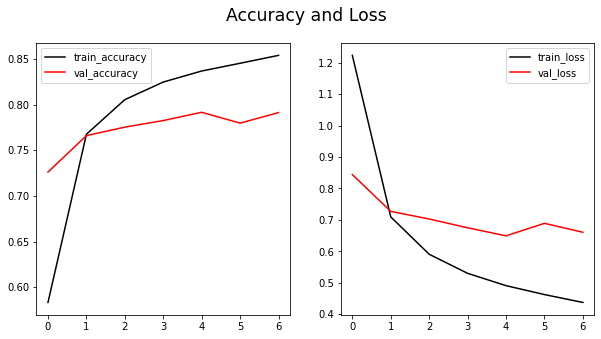

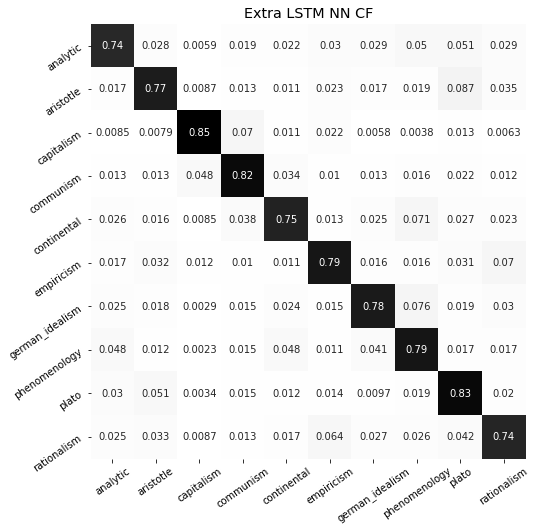




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.86      0.74      0.79     13461
           1       0.85      0.77      0.81     12359
           2       0.85      0.85      0.85      4452
           3       0.70      0.82      0.76      4505
           4       0.81      0.75      0.78      8356
           5       0.70      0.79      0.74      5015
           6       0.84      0.78      0.81     10495
           7       0.67      0.79      0.72      7049
           8       0.73      0.83      0.78      9590
           9       0.67      0.74      0.71      5753

    accuracy                           0.78     81035
   macro avg       0.77      0.78      0.77     81035
weighted avg       0.79      0.78      0.78     81035



In [30]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_LSTM_neurons_history, test, preds, labels=flipped_dict, title='Extra LSTM NN CF')

This actually seems to have gotten mildly worse. Let's see if adding a dense layer changes anything.

#### Adding Dense Layers

In [31]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='extra_dense_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         10861056  
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

None

In [32]:
extra_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 79s 102ms/step - loss: 2.0026 - accuracy: 0.2423 - val_loss: 1.3098 - val_accuracy: 0.5410
Epoch 2/20
760/760 [==============================] - 76s 100ms/step - loss: 1.3660 - accuracy: 0.4990 - val_loss: 1.0983 - val_accuracy: 0.6297
Epoch 3/20
760/760 [==============================] - 76s 100ms/step - loss: 1.1593 - accuracy: 0.5877 - val_loss: 1.0372 - val_accuracy: 0.6754
Epoch 4/20
760/760 [==============================] - 76s 100ms/step - loss: 1.0336 - accuracy: 0.6455 - val_loss: 1.0064 - val_accuracy: 0.6994
Epoch 5/20
760/760 [==============================] - 76s 100ms/step - loss: 0.9315 - accuracy: 0.6859 - val_loss: 0.9692 - val_accuracy: 0.7228
Epoch 6/20
760/760 [==============================] - 76s 99ms/step - loss: 0.8608 - accuracy: 0.7078 - val_loss: 1.0274 - val_accuracy: 0.7302
Epoch 7/20
760/760 [==============================] - 76s 100ms/step - loss: 0.8069 - accuracy: 0.7252 - val_loss: 1.0232 - val_acc

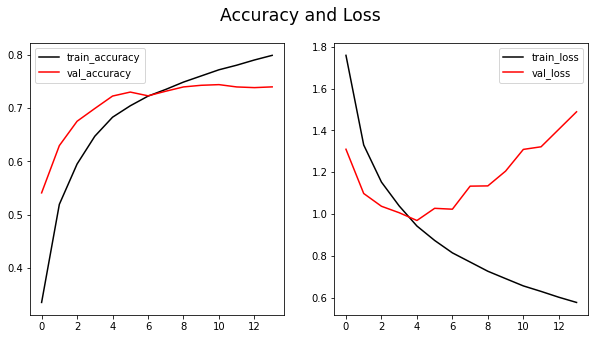

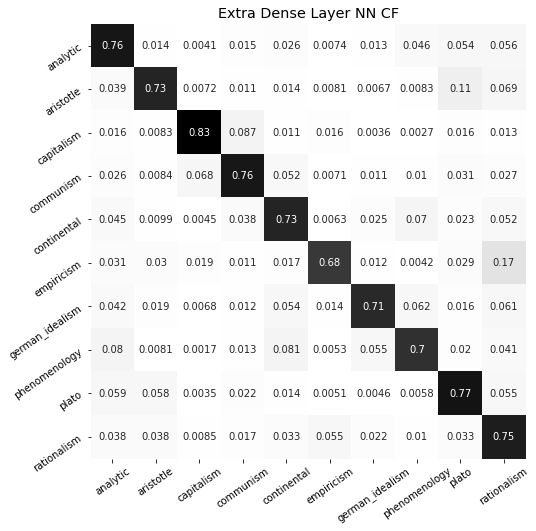




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.77      0.76      0.77     13225
           1       0.85      0.73      0.78     12154
           2       0.83      0.83      0.83      4445
           3       0.68      0.76      0.72      4616
           4       0.73      0.73      0.73      8576
           5       0.79      0.68      0.73      4981
           6       0.87      0.71      0.78     10518
           7       0.70      0.70      0.70      7173
           8       0.70      0.77      0.74      9601
           9       0.49      0.75      0.59      5746

    accuracy                           0.74     81035
   macro avg       0.74      0.74      0.74     81035
weighted avg       0.76      0.74      0.74     81035



In [33]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_dense_history, test, preds, labels=flipped_dict, title='Extra Dense Layer NN CF')

This one actually seemed to do worse than most of the other models. A dense layer doesn't seem to improve performance. 

#### Batch Size Changes

First, the baseline model but with double the batch size.

In [34]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='big_batch_size.pkl.')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         10842496  
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 10,878,806
Trainable params: 10,878,806
Non-trainable params: 0
_________________________________________________________________


None

In [35]:
more_batches_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
380/380 [==============================] - 47s 120ms/step - loss: 1.7944 - accuracy: 0.3632 - val_loss: 1.0054 - val_accuracy: 0.6748
Epoch 2/10
380/380 [==============================] - 45s 118ms/step - loss: 0.8466 - accuracy: 0.7223 - val_loss: 0.8004 - val_accuracy: 0.7416
Epoch 3/10
380/380 [==============================] - 45s 119ms/step - loss: 0.6511 - accuracy: 0.7892 - val_loss: 0.7141 - val_accuracy: 0.7696
Epoch 4/10
380/380 [==============================] - 45s 119ms/step - loss: 0.5556 - accuracy: 0.8182 - val_loss: 0.6770 - val_accuracy: 0.7799
Epoch 5/10
380/380 [==============================] - 45s 118ms/step - loss: 0.4926 - accuracy: 0.8382 - val_loss: 0.6728 - val_accuracy: 0.7824
Epoch 6/10
380/380 [==============================] - 45s 119ms/step - loss: 0.4513 - accuracy: 0.8502 - val_loss: 0.6671 - val_accuracy: 0.7869
Epoch 7/10
380/380 [==============================] - 45s 119ms/step - loss: 0.4178 - accuracy: 0.8601 - val_loss: 0.6729 - val_ac

Not any real improvement here.

Next let's try the same but with a smaller batch size.

In [36]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         10854144  
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
Total params: 10,890,454
Trainable params: 10,890,454
Non-trainable params: 0
_________________________________________________________________


None

In [37]:
more_batches_more_dense_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=32, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
6078/6078 [==============================] - 235s 38ms/step - loss: 1.3734 - accuracy: 0.5339 - val_loss: 0.8222 - val_accuracy: 0.7320
Epoch 2/10
6078/6078 [==============================] - 234s 39ms/step - loss: 0.7109 - accuracy: 0.7693 - val_loss: 0.7167 - val_accuracy: 0.7678
Epoch 3/10
6078/6078 [==============================] - 237s 39ms/step - loss: 0.5933 - accuracy: 0.8059 - val_loss: 0.6862 - val_accuracy: 0.7790
Epoch 4/10
6078/6078 [==============================] - 235s 39ms/step - loss: 0.5445 - accuracy: 0.8231 - val_loss: 0.6624 - val_accuracy: 0.7859
Epoch 5/10
6078/6078 [==============================] - 235s 39ms/step - loss: 0.5106 - accuracy: 0.8334 - val_loss: 0.6748 - val_accuracy: 0.7836
Epoch 6/10
6078/6078 [==============================] - 234s 39ms/step - loss: 0.4771 - accuracy: 0.8441 - val_loss: 0.6633 - val_accuracy: 0.7895
Epoch 7/10
6078/6078 [==============================] - 235s 39ms/step - loss: 0.4554 - accuracy: 0.8507 - val_loss: 0

Not much luck there either. Now we get extra experimental.

#### A Bit of Everything!

In [38]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# two dense layers, an LSTM layer, and a bi-directional layer!
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         10858752  
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
dense_11 (Dense)             (None, None, 25)          1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 25)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               30400     
_________________________________________________________________
dense_12 (Dense)             (None, 25)                2525      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)               

None

In [39]:
LSTM_bi_dense_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
380/380 [==============================] - 91s 230ms/step - loss: 2.0317 - accuracy: 0.2244 - val_loss: 1.2589 - val_accuracy: 0.5693
Epoch 2/10
380/380 [==============================] - 86s 226ms/step - loss: 1.2467 - accuracy: 0.5610 - val_loss: 1.0224 - val_accuracy: 0.6665
Epoch 3/10
380/380 [==============================] - 86s 227ms/step - loss: 1.0173 - accuracy: 0.6598 - val_loss: 0.9187 - val_accuracy: 0.7032
Epoch 4/10
380/380 [==============================] - 86s 227ms/step - loss: 0.8799 - accuracy: 0.7114 - val_loss: 0.8955 - val_accuracy: 0.7194
Epoch 5/10
380/380 [==============================] - 86s 226ms/step - loss: 0.7927 - accuracy: 0.7422 - val_loss: 0.8912 - val_accuracy: 0.7294
Epoch 6/10
380/380 [==============================] - 86s 227ms/step - loss: 0.7266 - accuracy: 0.7632 - val_loss: 0.9090 - val_accuracy: 0.7322
Epoch 7/10
380/380 [==============================] - 86s 226ms/step - loss: 0.6663 - accuracy: 0.7834 - val_loss: 0.8986 - val_ac

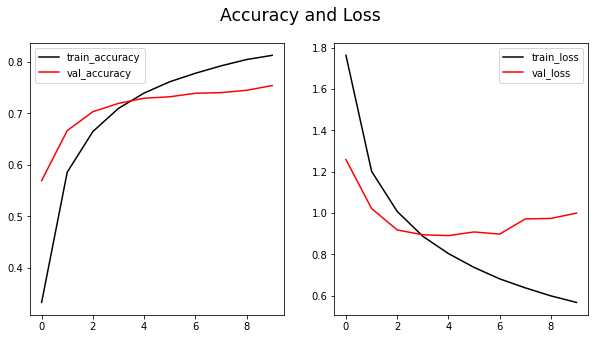

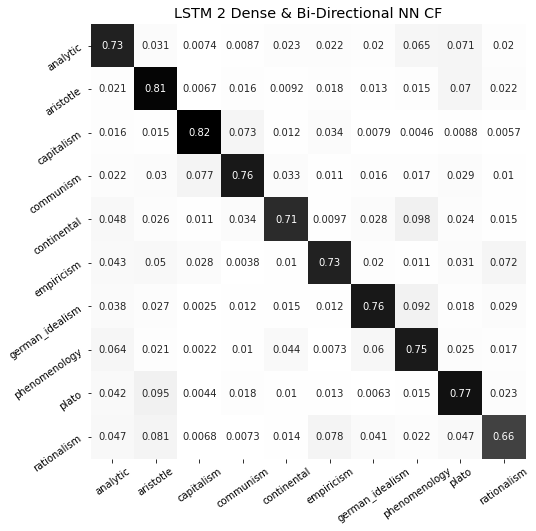




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.73      0.76     13321
           1       0.77      0.81      0.79     12121
           2       0.81      0.82      0.82      4540
           3       0.71      0.76      0.73      4463
           4       0.82      0.71      0.76      8645
           5       0.70      0.73      0.72      4944
           6       0.83      0.76      0.79     10585
           7       0.62      0.75      0.68      7151
           8       0.71      0.77      0.74      9522
           9       0.69      0.66      0.67      5743

    accuracy                           0.75     81035
   macro avg       0.75      0.75      0.75     81035
weighted avg       0.76      0.75      0.75     81035



In [40]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(LSTM_bi_dense_history, test, preds, labels=flipped_dict, title='LSTM 2 Dense & Bi-Directional NN CF')

These results were again in the range of the rest. At this point it's clear that we can achieve about 75% accuracy with most types of models; we're looking for something that can jump us up to 80% or more.

Let's try extra dense layers, this time with three of them. 

In [41]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# three dense layers on top of an LSTM layer
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(75, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         10878464  
_________________________________________________________________
lstm_11 (LSTM)               (None, 75)                61200     
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1900      
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 25)              

None

In [42]:
# extra epochs since the last extra dense layer model seemed to improve for longer
triple_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 83s 107ms/step - loss: 2.0596 - accuracy: 0.2234 - val_loss: 1.4186 - val_accuracy: 0.4948
Epoch 2/20
760/760 [==============================] - 82s 108ms/step - loss: 1.4266 - accuracy: 0.4689 - val_loss: 1.1239 - val_accuracy: 0.6166
Epoch 3/20
760/760 [==============================] - 83s 109ms/step - loss: 1.1672 - accuracy: 0.5929 - val_loss: 1.0144 - val_accuracy: 0.6711
Epoch 4/20
760/760 [==============================] - 82s 107ms/step - loss: 1.0172 - accuracy: 0.6674 - val_loss: 0.9720 - val_accuracy: 0.7174
Epoch 5/20
760/760 [==============================] - 81s 106ms/step - loss: 0.9255 - accuracy: 0.7076 - val_loss: 0.9715 - val_accuracy: 0.7288
Epoch 6/20
760/760 [==============================] - 82s 108ms/step - loss: 0.8241 - accuracy: 0.7454 - val_loss: 0.9752 - val_accuracy: 0.7379
Epoch 7/20
760/760 [==============================] - 81s 107ms/step - loss: 0.7672 - accuracy: 0.7657 - val_loss: 1.0085 - val_ac

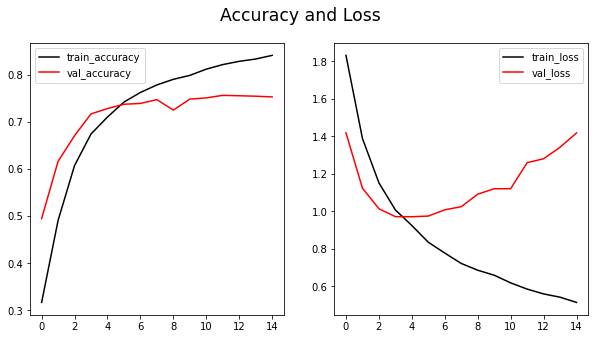

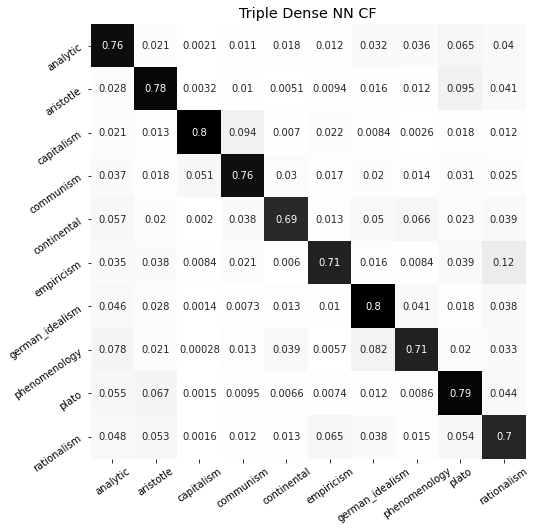




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.77      0.76      0.77     13324
           1       0.81      0.78      0.80     12100
           2       0.90      0.80      0.85      4547
           3       0.70      0.76      0.73      4521
           4       0.85      0.69      0.76      8450
           5       0.76      0.71      0.73      5007
           6       0.79      0.80      0.80     10508
           7       0.73      0.71      0.72      7139
           8       0.70      0.79      0.74      9704
           9       0.56      0.70      0.62      5735

    accuracy                           0.75     81035
   macro avg       0.76      0.75      0.75     81035
weighted avg       0.76      0.75      0.76     81035



In [43]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(triple_dense_history, test, preds, labels=flipped_dict, title='Triple Dense NN CF')

Not particularly inspiring, in fact this is worse than just two dense layers. 

We've tried a decent number of options here. Next let's see what happens if we bring in word embeddings from GloVe.

### Using Glove Word Embeddings

In [ ]:
glove_file = datapath('/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.300d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='glove_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(glove_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          20000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
Total params: 20,021,735
Trainable params: 21,735
Non-trainable params: 20,000,000
_________________________________________________________________


None

In [ ]:
glove_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 29s 35ms/step - loss: 2.2821 - accuracy: 0.1223 - val_loss: 2.1441 - val_accuracy: 0.2018
Epoch 2/20
760/760 [==============================] - 26s 35ms/step - loss: 2.1268 - accuracy: 0.1965 - val_loss: 2.0020 - val_accuracy: 0.2669
Epoch 3/20
760/760 [==============================] - 26s 35ms/step - loss: 2.0006 - accuracy: 0.2497 - val_loss: 1.9337 - val_accuracy: 0.2933
Epoch 4/20
760/760 [==============================] - 26s 35ms/step - loss: 1.9280 - accuracy: 0.2780 - val_loss: 1.8772 - val_accuracy: 0.3182
Epoch 5/20
760/760 [==============================] - 26s 35ms/step - loss: 1.8686 - accuracy: 0.3038 - val_loss: 1.8371 - val_accuracy: 0.3232
Epoch 6/20
760/760 [==============================] - 26s 34ms/step - loss: 1.8166 - accuracy: 0.3210 - val_loss: 1.7941 - val_accuracy: 0.3459
Epoch 7/20
760/760 [==============================] - 26s 35ms/step - loss: 1.7888 - accuracy: 0.3332 - val_loss: 1.7685 - val_accuracy:

Not very promising - perhaps the vectors that worked from 
GloVe and were trained on our data would be better?

### Custom Word Embeddings

Initial efforts to build models with our custom embeddings did have promising results. We did want to work more on tuning hyperparameters, but encountered problems with our w2v model size. In the end, we didn't have time to explore this avenue further. 

In [ ]:
custom_vectors = KeyedVectors.load('/gdrive/MyDrive/Colab_Projects/Phil_NLP/w2v_models/w2v_for_nn.wordvectors')

In [ ]:
custom_vectors.most_similar('philosophy')

[('metaphysics', 0.7894171476364136),
 ('theology', 0.7694715261459351),
 ('religion', 0.7320282459259033),
 ('science', 0.728236734867096),
 ('philosophical', 0.7186429500579834),
 ('transcendental philosophy', 0.7153382301330566),
 ('natural science', 0.7118123769760132),
 ('psychology', 0.7090511322021484),
 ('politics', 0.6923774480819702),
 ('skepticism', 0.6838987469673157)]

In [ ]:
tokenizer, x_train_seqx_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='custom_w2v_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(custom_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

In [ ]:
len(tokenizer.word_index)

In [ ]:
len(custom_vectors.vocab)

In [ ]:
custom_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

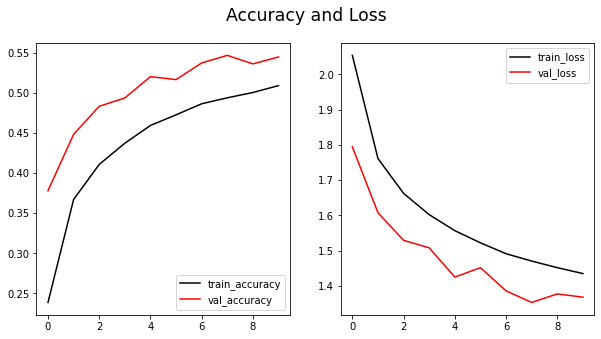

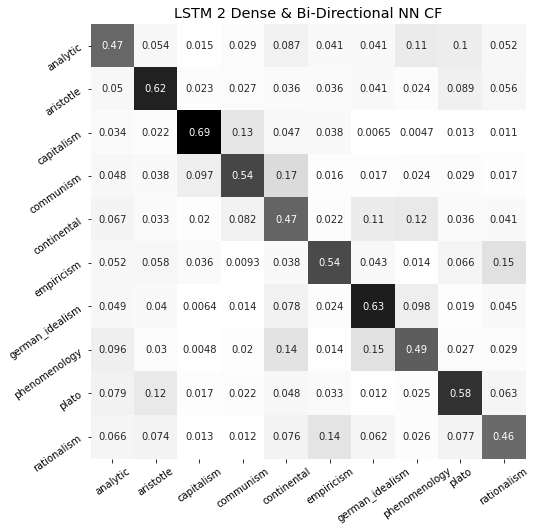




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.60      0.47      0.52     13403
           1       0.68      0.62      0.65     12702
           2       0.66      0.69      0.68      4640
           3       0.49      0.54      0.51      4601
           4       0.42      0.47      0.44      8329
           5       0.48      0.54      0.51      5062
           6       0.63      0.63      0.63     10554
           7       0.44      0.49      0.47      7140
           8       0.57      0.58      0.58      9659
           9       0.40      0.46      0.43      5722

    accuracy                           0.55     81812
   macro avg       0.54      0.55      0.54     81812
weighted avg       0.56      0.55      0.55     81812



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(custom_embeddings_LSTM_history, test, preds, labels=flipped_dict, title='Custom Embeddings LSTM NN CF')

Above you can see the initial result of the model working with our w2v custom embeddings. 

### Conclusion

Overall, deep NLP yielded the best models that we had in our project, with nearly 80% accuracy. 

RMSprop turned out to be a better optimizer than Adam for this dataset. 

Word embeddings did not yield promising results at first, but are something to explore further. We'd also like to try different optimizers.

Unfortunately, none of our models showed much impressive actual learning. Instead, they hit a certain accuracy within a couple epochs and would typically stay there with minor deviations as epochs went by; this is reflected in nearly all our training curves. We're not sure why we got this result and our future efforts would be directed to trying to fix this issue.

Nonetheless, 80% accuracy over 10 classes is a result we can be happy with. 